In [1]:
import numpy as np
import pandas as pd
import random
import nltk
import json
import csv
import os
import random
import cv2
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet, words
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from yellowbrick.text import PosTagVisualizer
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

In [2]:
def load_and_preprocess_data(file_path, n_samples=5000):
    """
    Charge et pré-traite les données à partir d'un fichier JSON. La fonction lit le fichier,
    convertit les données en DataFrame, sélectionne les revues ayant un nombre d'étoiles
    inférieur ou égal à 2 et retourne un sous-ensemble aléatoire de ces revues.

    Args:
        file_path (str): Chemin d'accès au fichier JSON contenant les revues.
        n_samples (int, optional): Nombre de revues à sélectionner dans le sous-ensemble. Par défaut à 5000.

    Returns:
        pandas.DataFrame: Sous-ensemble de revues négatives sélectionnées aléatoirement.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        reviews = [json.loads(line) for line in f]
    reviews_df = pd.DataFrame(reviews)
    negative_reviews = reviews_df[reviews_df["stars"] <= 2]
    subset = negative_reviews.sample(n=n_samples, random_state=0)

    return subset


negative_reviews = load_and_preprocess_data("data/yelp_academic_dataset_review.json")

In [3]:
data = negative_reviews.copy()

### Structure du jeu de données

In [4]:
def analyse_structure(df):
    """
    Analyse la structure d'un DataFrame pandas et affiche les informations pertinentes,
    telles que sa forme, le nombre de valeurs uniques dans chaque colonne, les types de données
    et les colonnes avec moins de 10 ou plus de 1000 valeurs uniques.

    Args:
        df (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche les informations directement.

    """
    print("Forme du Dataframe:", data.shape)
    print(data.info(), "\n")
    print(data.dtypes.value_counts(), "\n")
    print(data.nunique(), "\n")
    tmp = data.nunique()
    print(tmp[tmp < 10], "\n")
    print(tmp[tmp > 1000])


analyse_structure(data)

Forme du Dataframe: (5000, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1133760 to 3860028
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    5000 non-null   object 
 1   user_id      5000 non-null   object 
 2   business_id  5000 non-null   object 
 3   stars        5000 non-null   float64
 4   useful       5000 non-null   int64  
 5   funny        5000 non-null   int64  
 6   cool         5000 non-null   int64  
 7   text         5000 non-null   object 
 8   date         5000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 390.6+ KB
None 

object     5
int64      3
float64    1
Name: count, dtype: int64 

review_id      5000
user_id        4943
business_id    4609
stars             2
useful           31
funny            20
cool             15
text           5000
date           5000
dtype: int64 

stars    2
dtype: int64 

review_id      5000
user_id        4943

### Nan et duplicated

review_id      0.0
user_id        0.0
business_id    0.0
stars          0.0
useful         0.0
funny          0.0
cool           0.0
text           0.0
date           0.0
dtype: float64
0
0
col = review_id -> duplicated = 0
col = user_id -> duplicated = 57
col = business_id -> duplicated = 391
col = stars -> duplicated = 4998
col = useful -> duplicated = 4969
col = funny -> duplicated = 4980
col = cool -> duplicated = 4985
col = text -> duplicated = 0
col = date -> duplicated = 0


1133760    False
4434849    False
4632955    False
5699501    False
6075839    False
           ...  
5057473    False
2254512    False
6242417    False
5196644    False
3860028    False
Name: text, Length: 5000, dtype: bool


,stars,useful,funny,cool
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.341600,1.499000,0.434000,0.187600
std,0.474294,2.776462,1.439326,0.846492
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,0.000000
max,2.000000,40.000000,51.000000,23.000000


,review_id,user_id,business_id,text,date
count,5000,5000,5000,5000,5000
unique,5000,4943,4609,5000,5000
top,Ssy6lXyaK4rEc90N8FCPmg,1p8Pu1pvAsuNtuZDtn2OkQ,IkY2ticzHEn4QFn8hQLSWg,Terribly long wait times. Their A/C must be on...,2014-06-26 22:54:22
freq,1,3,7,1,1


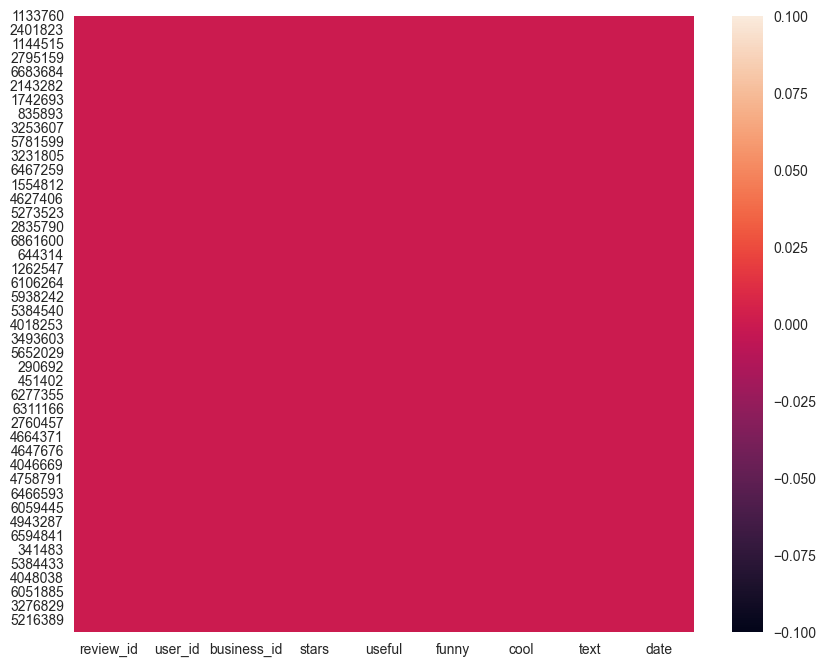

In [5]:
def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print(data.duplicated().sum())
    print(data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))


analyse_data(negative_reviews)

In [6]:
print(negative_reviews.text.apply(lambda x: len(x)))

1133760     405
4434849    1250
4632955    1721
5699501     204
6075839    1055
           ... 
5057473     222
2254512     259
6242417    1092
5196644     296
3860028     719
Name: text, Length: 5000, dtype: int64


### Analyse des commentaires négatifs

Text(0.5, 1.0, 'Distribution du nombre de caractères des avis négatifs')

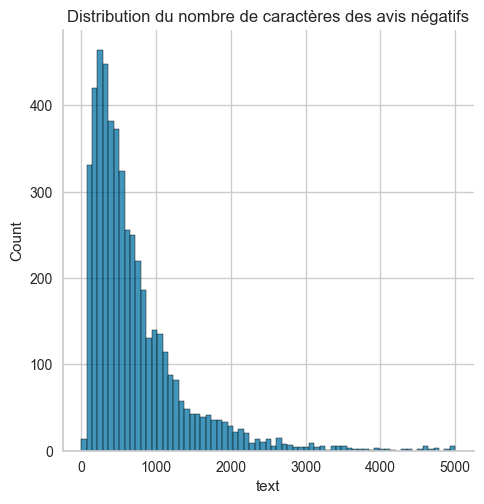

In [7]:
tmp = negative_reviews.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des avis négatifs")

In [8]:
def display_reviews(df, col):
    """
    Affiche la valeur de la colonne 'stars' et la valeur d'une autre colonne spécifiée pour un échantillon aléatoire
    d'une ligne du DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame contenant les revues.
        col (str): Nom de la colonne dont la valeur doit être affichée.

    Returns:
        None. Cette fonction affiche directement les informations.
    """
    rand_index = random.randint(0, df.shape[0])
    print(df.stars.iloc[rand_index])
    display(df[col].iloc[rand_index])

In [9]:
negative_reviews.stars.value_counts()

stars
1.0    3292
2.0    1708
Name: count, dtype: int64

In [10]:
display_reviews(negative_reviews, "text")

1.0


'While i was there the owner guy was speaking very derogatively towards the ladies (staff) and i could see the discomfort on their faces. I understand their language and i thought it was a one off incident, but this guy was repeatedly being abusive even when the staff were doing their jobs. Seems like this owner has a size problem! ;)\nI felt so uncomfortable i had to throw my food and get out of there!'

In [11]:
english_words = set(words.words())

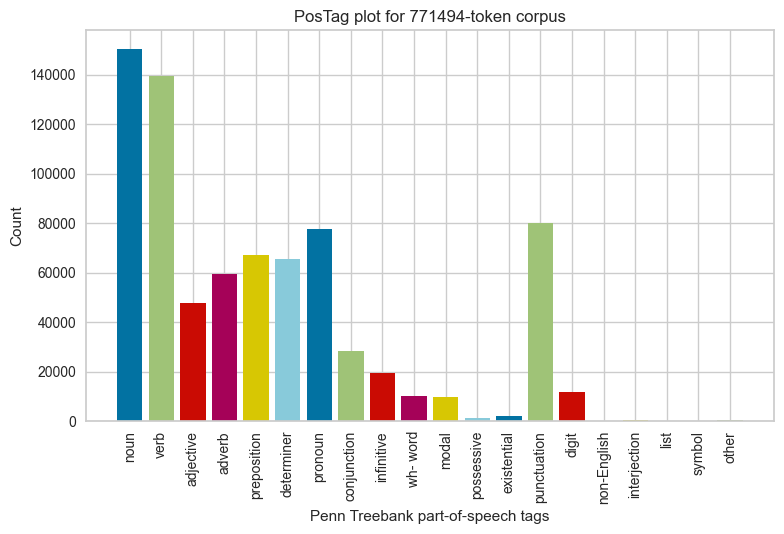

In [12]:
def visualize_pos_tag(df):
    """
    Visualise les étiquettes de parties du discours (Part of Speech, POS) dans les commentaires (ou 'reviews')
    contenus dans le DataFrame fourni.

    Cette fonction utilise la bibliothèque nltk pour séparer les commentaires en phrases et en mots,
    et ensuite attribuer à chaque mot une étiquette de partie du discours. Elle utilise ensuite la classe
    PosTagVisualizer de la bibliothèque yellowbrick pour visualiser les résultats.

    Args:
        df (pandas.DataFrame): DataFrame contenant une colonne 'text' où chaque entrée est un commentaire à analyser.

    Returns:
        None. La fonction affiche un graphique horizontal montrant la fréquence de chaque étiquette POS.
    """
    list_reviews = [review for review in df.text.values]
    tagged_stanzas = []
    for paragraph in list_reviews:
        tagged_sentences = []
        sentences = nltk.sent_tokenize(paragraph)
        for sentence in sentences:
            words = nltk.word_tokenize(sentence)
            tagged_words = nltk.pos_tag(words)
            tagged_sentences.append(tagged_words)
        tagged_stanzas.append(tagged_sentences)
    viz = PosTagVisualizer(orient="h")
    viz.fit(tagged_stanzas)
    viz.show()


visualize_pos_tag(negative_reviews)

In [13]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')


def get_wordnet_pos(treebank_tag):
    """
    Convertit les étiquettes de parties du discours (Part of Speech, POS) de Penn Treebank en format WordNet.

    Args:
        treebank_tag (str): Étiquette de partie du discours au format Penn Treebank.

    Returns:
        str: Étiquette de partie du discours au format WordNet.
    """
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # by default it is NOUN


def preprocess_text(text, english_words=english_words, min_len_word=3, rejoin=False):
    """
    Pré-traite un texte en réalisant plusieurs opérations : conversion en minuscules, suppression des caractères non
    alphabétiques, élimination des stop words, lemmatisation et filtration des mots courts.

    Args:
        text (str): Texte à pré-traiter.
        english_words (set): Ensemble des mots anglais à considérer.
        min_len_word (int): Longueur minimale des mots à conserver.
        rejoin (bool): Si True, renvoie le texte pré-traité sous forme d'une chaîne de caractères.

    Returns:
        list or str: Texte pré-traité sous forme d'une liste de mots ou d'une chaîne de caractères (si rejoin=True).
    """
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    stop_words = set(stopwords.words("english"))
    words = [word for word in text.split() if word not in stop_words]
    filtered_corpus = [word for word in words if word in english_words]

    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(filtered_corpus)
    words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_words
    ]

    final_tokens = [w for w in words if len(w) >= min_len_word]

    if rejoin:
        return " ".join(final_tokens)

    return final_tokens


def clean_dataset(doc):
    """
    Nettoie un document en utilisant la fonction preprocess_text avec rejoin=True.

    Args:
        doc (str): Document à nettoyer.

    Returns:
        str: Document nettoyé.
    """
    new_doc = preprocess_text(doc, rejoin=True)
    return new_doc


negative_reviews["cleaned_text"] = negative_reviews["text"].apply(clean_dataset)
negative_reviews.to_pickle("sample_text_data.pkl")

In [14]:
raw_corpus = " ".join(negative_reviews.text.values)
corpus = preprocess_text(raw_corpus)

In [15]:
display_reviews(negative_reviews, "cleaned_text")

2.0


'consistently rather unimpressed restaurant always dark loud music somewhat save grace restaurant open late adult near house'

In [16]:
raw_corpus[:100]

'Terribly long wait times. Their A/C must be on the fritz, not only was the wait time close to 3 hour'

In [17]:
def display_tokens_info(tokens):
    """
    Affiche des informations sur une liste de tokens, notamment le nombre total de tokens,
    le nombre de tokens uniques et les 100 premiers tokens.

    Args:
        tokens (list of str): Liste de tokens.

    Returns:
        None. Cette fonction affiche directement les informations.
    """
    print(f"nombre tokens {len(tokens)}, nombres tokens uniques {len(set(tokens))}")
    print(tokens[:100])


display_tokens_info(corpus)

nombre tokens 254868, nombres tokens uniques 9153
['terribly', 'long', 'wait', 'time', 'must', 'wait', 'time', 'close', 'temp', 'building', 'possibly', 'felt', 'like', 'sweat', 'shop', 'feel', 'people', 'work', 'even', 'good', 'disposition', 'time', 'get', 'help', 'hard', 'grouchy', 'next', 'time', 'pay', 'small', 'fee', 'road', 'express', 'get', 'soon', 'friend', 'get', 'sot', 'beef', 'lunch', 'soup', 'good', 'spicy', 'even', 'sure', 'felt', 'burn', 'admit', 'tend', 'eat', 'make', 'tear', 'bit', 'disappointed', 'unnamed', 'pile', 'stuff', 'good', 'tofu', 'come', 'whole', 'head', 'shell', 'even', 'sure', 'suppose', 'eat', 'soup', 'take', 'crack', 'open', 'feel', 'quite', 'primitive', 'process', 'friend', 'beautiful', 'flavor', 'however', 'bit', 'bland', 'something', 'bowl', 'hot', 'probably', 'also', 'due', 'user', 'error', 'certain', 'extent', 'rice', 'bottom', 'burn', 'together', 'bit', 'crispy', 'rice', 'pancake', 'good']


On observe dans les 30 premiers tokens, certains tokens intéressants dans le contexte de notre projet comme : disappointment, dirty, disgusting etc...

In [18]:
tmp = pd.Series(corpus).value_counts()
tmp.head(10)

get      3897
food     3029
time     2790
order    2520
would    2457
say      2375
one      2280
come     2253
place    2177
like     2158
Name: count, dtype: int64

In [19]:
rare_words = tmp[tmp <= 5]
list_rare_words = rare_words.index.to_list()
tmp = pd.DataFrame({"words": rare_words})
tmp.to_csv("data/rare_words.csv", index=False)

In [20]:
print(
    "Nombres de mots dont la fréquence d'apparition est inférieure à 5:",
    len(list_rare_words),
)
print(rare_words.head(10))

Nombres de mots dont la fréquence d'apparition est inférieure à 5: 5820
freezing         5
passing          5
verification     5
ethical          5
tunnel           5
yep              5
beforehand       5
irresponsible    5
diverse          5
locker           5
Name: count, dtype: int64


###  Bow : Bag of Words
- CountVectorizer: C'est l'implémentation la plus simple de BoW. Il convertit le texte en un vecteur sur la base du nombre d'occurrences de chaque mot dans le texte. Il compte simplement le nombre de fois qu'un mot apparaît dans le document. 

### Modelisation de sujets : méthodes non supervisées

- LDA : LDA est une méthode probabiliste qui suppose que chaque document est une combinaison de sujets, et que chaque mot dans le document est attribué à l'un des sujets du document. LDA tente d'apprendre les distributions de sujets-mots et de documents-sujets qui ont probablement généré le corpus.

In [21]:
num_topics = 4

In [22]:
def topic_modeling_lda(reviews, num_topics=num_topics):
    """
    Vectorise le corpus en utilisant CountVectorizer et crée le modèle LDA. Retourne le modèle, le vectorizer, les vecteurs de
    sujet pour chaque document et la matrice de comptage.

    Args:
        reviews (list of str): Liste des revues à analyser.
        num_topics (int): Nombre de sujets à générer avec le modèle LDA.

    Returns:
        tuple: Quadruplet contenant le modèle LDA, le vectorizer, les vecteurs de sujet et la matrice de comptage.
    """
    vectorizer = CountVectorizer(
        max_df=0.95, min_df=3, max_features=1000, stop_words="english"
    )
    count_matrix = vectorizer.fit_transform(reviews)
    lda_model = LatentDirichletAllocation(
        n_components=num_topics, learning_method="online", random_state=0
    )
    lda_model.fit(count_matrix)
    topic_vectors = lda_model.transform(count_matrix)
    return lda_model, vectorizer, topic_vectors, count_matrix


def display_topics(model, vectorizer, no_top_words=15):
    """
    Affiche les principaux mots pour chaque sujet généré par un modèle LDA.

    Args:
        model (LatentDirichletAllocation): Modèle LDA.
        vectorizer (CountVectorizer): Vectorizer utilisé pour transformer le corpus.
        no_top_words (int): Nombre de principaux mots à afficher pour chaque sujet.

    Returns:
        list of str: Liste de tous les mots uniques présents dans le corpus utilisés par le vectorizer.
    """
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(
            " ".join(
                [feature_names[i] for i in topic.argsort()[: -no_top_words - 1 : -1]]
            )
        )
    return feature_names

In [23]:
preprocessed_reviews = [review for review in negative_reviews.cleaned_text.values]
lda_model, count_vectorizer, topic_vectors, dtm = topic_modeling_lda(
    preprocessed_reviews, num_topics=num_topics
)
print("LDA Topics:")
lda_features_names = display_topics(lda_model, count_vectorizer)

LDA Topics:
Topic 0:
service customer order store time tell manager say rude phone business make owner bad delivery
Topic 1:
food order good come like place time table restaurant service eat chicken taste say really
Topic 2:
time say tell come car day work make like leave wait look pay know try
Topic 3:
place room like night stay people hotel bar staff door coffee dirty outside clean come


#### Mesures de cohérence
Examinons rapidement les différentes mesures de cohérence et leur mode de calcul :

1. la mesure C_v est basée sur une fenêtre coulissante, une segmentation en un seul ensemble des mots les plus importants et une mesure de confirmation indirecte qui utilise l'information mutuelle ponctuelle normalisée (NPMI) et la similarité cosinus.

2. la mesure C_uci est basée sur une fenêtre coulissante et l'information mutuelle ponctuelle (PMI) de toutes les paires de mots des mots principaux donnés

3. la mesure C_umass est basée sur le nombre de cooccurrences dans les documents, une segmentation à un précédant et une probabilité conditionnelle logarithmique comme mesure de confirmation

4. C_npmi est une version améliorée de la cohérence C_uci utilisant l'information mutuelle ponctuelle normalisée (NPMI).

In [24]:
def get_Cv(model, feature_names, df_column):
    """
    Calcule et renvoie le score de cohérence pour un modèle LDA, basé sur les 10 principaux mots de chaque sujet.
    Le score de cohérence mesure la qualité d'un modèle de sujet en examinant la cohérence des mots qui constituent chaque sujet.

    Args:
        model (LatentDirichletAllocation): Modèle LDA.
        feature_names (list of str): Liste des mots de fonctionnalité utilisés par le vectorizer.
        df_column (pandas.Series): Colonnes du DataFrame contenant les textes prétraités.

    Returns:
        float: Score de cohérence pour les 10 premiers mots de chaque sujet.
    """
    topics = model.components_
    n_top_words = 10
    texts = [[word for word in doc.split()] for doc in df_column]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    top_words = []
    for topic in topics:
        top_words.append(
            [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]
        )
    coherence_model = CoherenceModel(
        topics=top_words, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    coherence = coherence_model.get_coherence()
    return coherence


coherence = get_Cv(lda_model, lda_features_names, negative_reviews.cleaned_text)
print("Score de cohérence pour les 10 premiers mots de chaques topics:", coherence)

Score de cohérence pour les 10 premiers mots de chaques topics: 0.46271714397208263


#### Visualisation

C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.color

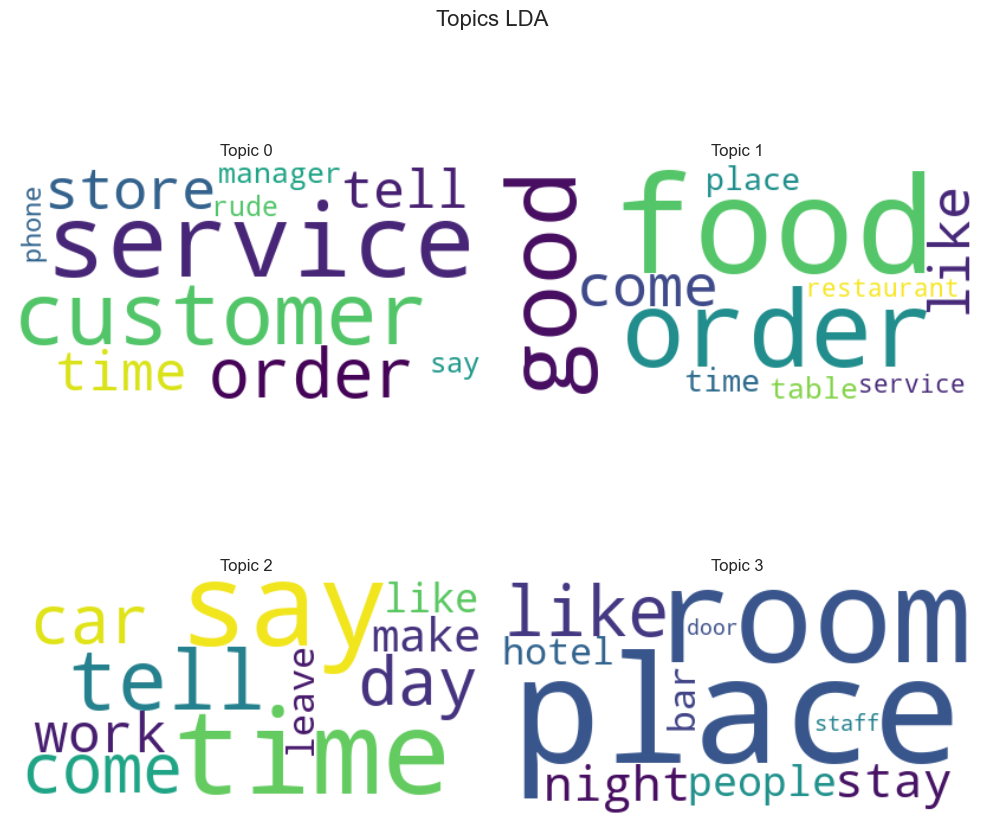

In [25]:
def plot_wordcloud(lda_model, lda_features_names, num_topics=4):
    """
    Affiche une visualisation de nuage de mots pour chaque sujet d'un modèle LDA.
    Chaque nuage de mots est basé sur les 10 mots les plus importants de chaque sujet.

    Args:
        lda_model (LatentDirichletAllocation): Modèle LDA.
        lda_features_names (list of str): Liste des mots de fonctionnalité utilisés par le vectorizer.
        num_topics (int, optional): Nombre de sujets à visualiser. Par défaut à 4.

    Returns:
        None. Cette fonction affiche directement les nuages de mots.
    """
    fig, axes = plt.subplots(int(num_topics / 2), 2, figsize=(10, 10))

    for i in range(num_topics):
        topic_words = lda_model.components_[i]
        top_word_indices = topic_words.argsort()[:-11:-1]
        wc_dict = {
            lda_features_names[index]: topic_words[index] for index in top_word_indices
        }
        wc = WordCloud(background_color="white")
        wc.generate_from_frequencies(wc_dict)
        ax = axes[i // 2, i % 2]
        ax.set_title(f"Topic {i}")
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
    plt.tight_layout()
    plt.suptitle("Topics LDA", fontsize=16)
    plt.show()


plot_wordcloud(lda_model, lda_features_names)

Ces résultats montrent les sujets principaux trouvés par l'analyse LDA. Chaque sujet est représenté par un ensemble de mots qui ont la plus grande probabilité d'apparaître dans ce sujet. 
Comme cité précèdemment, LDA semble en mesure de parcourir les thèmes généraux qui sont présents dans les documents, ces thèmes balayent :
- des problèmes liés au service à la clientèle, et plus précisément à la gestion des commandes.
- des sujets concernant la qualité de la nourriture et le service dans les restaurants.
- des sujets concernant des services automobiles, et plus précisement les temps de livraison.
- des sujets qui se concentre sur les hôtels, abordant des thèmes tels que la propreté des chambres, le personnel et les services offerts

In [26]:
#pyLDAvis.lda_model.prepare(lda_model, dtm, count_vectorizer, mds="mmds")

### Réduction de dimensionnalité

Les vecteurs de sujets, qui sont les sorties du modèle LDA, représentent la répartition des sujets pour chaque commentaire. Ils capturent l'information de haut niveau sur les "sujets" ou les thèmes principaux présents dans chaque commentaire. L'application de t-SNE sur ces vecteurs donnera une visualisation en 2D où chaque point représente un commentaire et les commentaires similaires en termes de sujets seront regroupés ensemble.

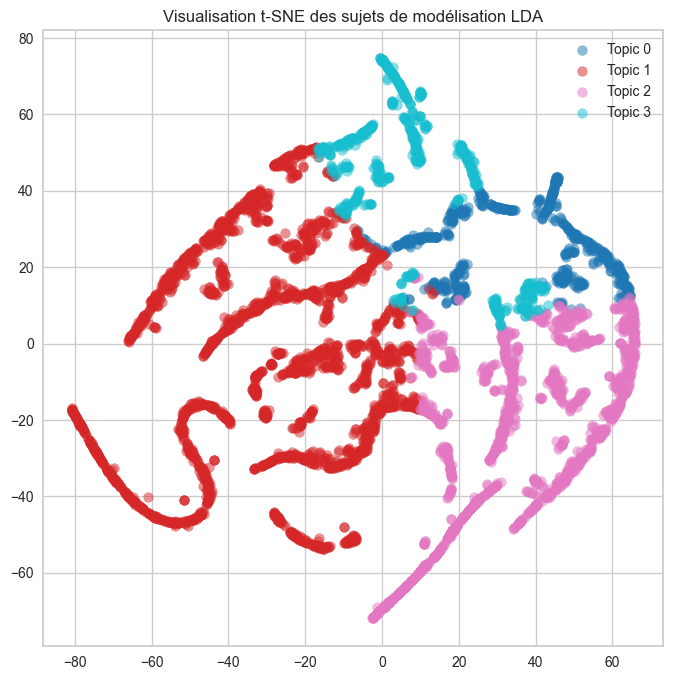

In [27]:
def plot_tsne(topic_vectors, num_topics=4):
    """
    Affiche une visualisation t-SNE (t-Distributed Stochastic Neighbor Embedding) des sujets d'un modèle LDA.
    Chaque point dans la visualisation représente un document, coloré en fonction de son sujet dominant.

    Args:
        topic_vectors (array-like): Vecteurs de sujet pour chaque document.
                                    C'est la sortie de la méthode 'transform' d'un modèle LDA.
        num_topics (int, optional): Nombre de sujets à visualiser. Par défaut à 4.

    Returns:
        numpy.ndarray: Tableau indiquant le sujet dominant pour chaque document.
    """
    dominant_topics = np.argmax(topic_vectors, axis=1)
    colors = np.array(
        [plt.cm.tab10(i / float(num_topics - 1)) for i in range(num_topics)]
    )
    tsne_model = TSNE(n_components=2, random_state=0)
    tsne_vectors = tsne_model.fit_transform(topic_vectors)
    plt.figure(figsize=(8, 8))
    for i in range(num_topics):
        plt.scatter(
            tsne_vectors[dominant_topics == i, 0],
            tsne_vectors[dominant_topics == i, 1],
            color=colors[i],
            label=f"Topic {i}",
            alpha=0.5,
        )
    plt.legend()
    plt.title("Visualisation t-SNE des sujets de modélisation LDA")
    plt.show()
    return dominant_topics


dominant_topics = plot_tsne(topic_vectors)

In [28]:
def count_maj_topic(dominant_topics):
    """
    Compte le nombre de documents attribués à chaque sujet et imprime le sujet le plus courant.

    Args:
        dominant_topics (numpy.ndarray): Tableau indiquant le sujet dominant pour chaque document.

    Returns:
        None. Cette fonction imprime directement le sujet le plus courant et son nombre de documents.
    """
    topic_counts = Counter(dominant_topics)
    major_topic = topic_counts.most_common(1)[0]
    print(
        f"Le topic majoritaire est le sujet {major_topic[0]} avec {major_topic[1]} documents."
    )


count_maj_topic(dominant_topics)

Le topic majoritaire est le sujet 1 avec 2419 documents.


#### Enchaînement des étapes de nettoyage et de création de variables

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Un transformateur personnalisé qui effectue un prétraitement sur du texte,
    comme la mise en minuscule, le filtrage des stopwords, la lemmatisation, etc.
    """

    def __init__(self, english_words=english_words, min_len_word=3, rejoin=True):
        self.english_words = english_words
        self.min_len_word = min_len_word
        self.rejoin = rejoin

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [
            preprocess_text(doc, self.english_words, self.min_len_word, self.rejoin)
            for doc in X
        ]


class TopicModeler(BaseEstimator, TransformerMixin):
    """
    Un transformateur personnalisé qui effectue une modélisation de sujet LDA sur du texte prétraité.
    """

    def __init__(self, num_topics=4):
        self.num_topics = num_topics

    def fit(self, X, y=None):
        (
            self.lda_model,
            self.count_vectorizer,
            self.topic_vectors,
            self.dtm,
        ) = topic_modeling_lda(X, self.num_topics)
        return self

    def transform(self, X):
        return self.lda_model.transform(self.count_vectorizer.transform(X))


text_pipeline = Pipeline(
    [
        (
            "preprocessing",
            TextPreprocessor(english_words=english_words, min_len_word=3, rejoin=True),
        ),
        ("topic_modeling", TopicModeler(num_topics=4)),
    ]
)

In [30]:
transformed_data = text_pipeline.fit_transform(negative_reviews["text"])

In [31]:
print(transformed_data)
print(transformed_data.shape)

[[0.01027347 0.01063304 0.96812908 0.01096441]
 [0.00482301 0.91057239 0.0800654  0.00453919]
 [0.12124493 0.00328625 0.63767085 0.23779797]
 ...
 [0.00616434 0.00610643 0.98161909 0.00611014]
 [0.38162885 0.01736607 0.58352224 0.01748283]
 [0.0090029  0.9729096  0.00898037 0.00910714]]
(5000, 4)


transformed_data correspond bien aux vecteurs de sujets renvoyé par LDA.

## Analyse des images

In [32]:
def load_image_data(file_path, n_samples=None):
    """
    Charge les données d'image depuis un fichier JSON et renvoie un DataFrame pandas.
    Si n_samples est spécifié, un sous-ensemble aléatoire des données est renvoyé.

    Args:
        file_path (str): Chemin vers le fichier de données à lire.
        n_samples (int, optional): Nombre d'échantillons à sélectionner aléatoirement. Si None, toutes les données sont utilisées.

    Returns:
        pandas.DataFrame: DataFrame contenant les données d'image.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        images = [json.loads(line) for line in f]
    df_images = pd.DataFrame(images)

    if n_samples:
        df_images = df_images.sample(n=n_samples)
    return df_images


df_images = load_image_data("data/photos.json")

In [33]:
def analyse_image(df):
    """
    Analyse un DataFrame contenant des données d'image. Affiche les cinq premières lignes,
    la forme du DataFrame, le nombre de doublons basé sur 'photo_id', les valeurs manquantes,
    le nombre de valeurs uniques par colonne et la distribution des valeurs de la colonne 'label'.

    Args:
        df (pandas.DataFrame): DataFrame contenant les données d'image à analyser.

    Returns:
        None. Les résultats sont affichés directement.
    """
    display(df.head())
    print(df.shape, "\n")
    print("Nombres de duplicatas :", df.photo_id.duplicated().sum(), "\n")
    df.drop_duplicates(subset="photo_id", inplace=True)
    print(df.isna().mean(), "\n")
    print("Nombre de données uniques: \n", df.nunique(), "\n")
    print(df.label.value_counts())


analyse_image(df_images)

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


(200100, 4) 

Nombres de duplicatas : 2 

photo_id       0.0
business_id    0.0
caption        0.0
label          0.0
dtype: float64 

Nombre de données uniques: 
 photo_id       200098
business_id     36680
caption         76413
label               5
dtype: int64 

label
food       108151
inside      56031
outside     18569
drink       15669
menu         1678
Name: count, dtype: int64


Nous avons supprimé les données dupliquées.

### Récupération et prétraitement de 200 images par catégories

In [34]:
def sample_df(df, n_samples=210):
    """
    Echantillonne un DataFrame en prenant un nombre égal d'échantillons de chaque label.

    Args:
        df (pandas.DataFrame): DataFrame à échantillonner.
        n_samples (int): Nombre d'échantillons à prendre pour chaque label.

    Returns:
        pandas.DataFrame: DataFrame échantillonné.
    """
    df_sampled = df.groupby("label").sample(n=n_samples, random_state=6)
    return df_sampled


def preprocess_image(image_path):
    """
    Prétraite une image : charge l'image en niveau de gris, applique un filtre Gaussien, égalise l'histogramme.

    Args:
        image_path (str): Chemin vers l'image à prétraiter.

    Returns:
        numpy.ndarray: Image prétraitée. None si l'image n'a pas pu être chargée.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"L'image n'a pas pu être chargée. Chemin d'accès : {image_path}")
        return None
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    return img


def get_images(df, input_dir):
    """
    Charge et pré-traite les images à partir d'un DataFrame et d'un répertoire d'entrée.
    Ne conserve que les images valides (jusqu'à 200 par label).

    Args:
        df (pandas.DataFrame): DataFrame contenant les identifiants et labels des images.
        input_dir (str): Répertoire contenant les images.

    Returns:
        list: Liste d'images prétraitées.
        list: Liste de labels correspondants.
    """
    images = []
    labels = []
    valid_images_per_label = {}

    for index, row in df.iterrows():
        image_id = row["photo_id"]
        label = row["label"]

        if valid_images_per_label.get(label, 0) >= 200:
            continue
        image_path = os.path.join(input_dir, f"{image_id}.jpg")
        img = preprocess_image(image_path)
        if img is not None:
            images.append(img)
            labels.append(label)
            valid_images_per_label[label] = valid_images_per_label.get(label, 0) + 1

    return images, labels


input_dir = "data/photos"
df_sampled = sample_df(df_images)
df_sampled.to_pickle("sample_image_data.pkl")
images, labels = get_images(df_sampled, input_dir)

In [35]:
print("Nombres de labels :", len(labels))
print("Nombres de labels uniques:", len(set(labels)))
compteur_labels = Counter(labels)
for label, count in compteur_labels.items():
    print("Le label", label, "apparaît", count, "fois.")

Nombres de labels : 1000
Nombres de labels uniques: 5
Le label drink apparaît 200 fois.
Le label food apparaît 200 fois.
Le label inside apparaît 200 fois.
Le label menu apparaît 200 fois.
Le label outside apparaît 200 fois.


Text(0.5, 0.98, "Echantillon d'images et de leurs labels")

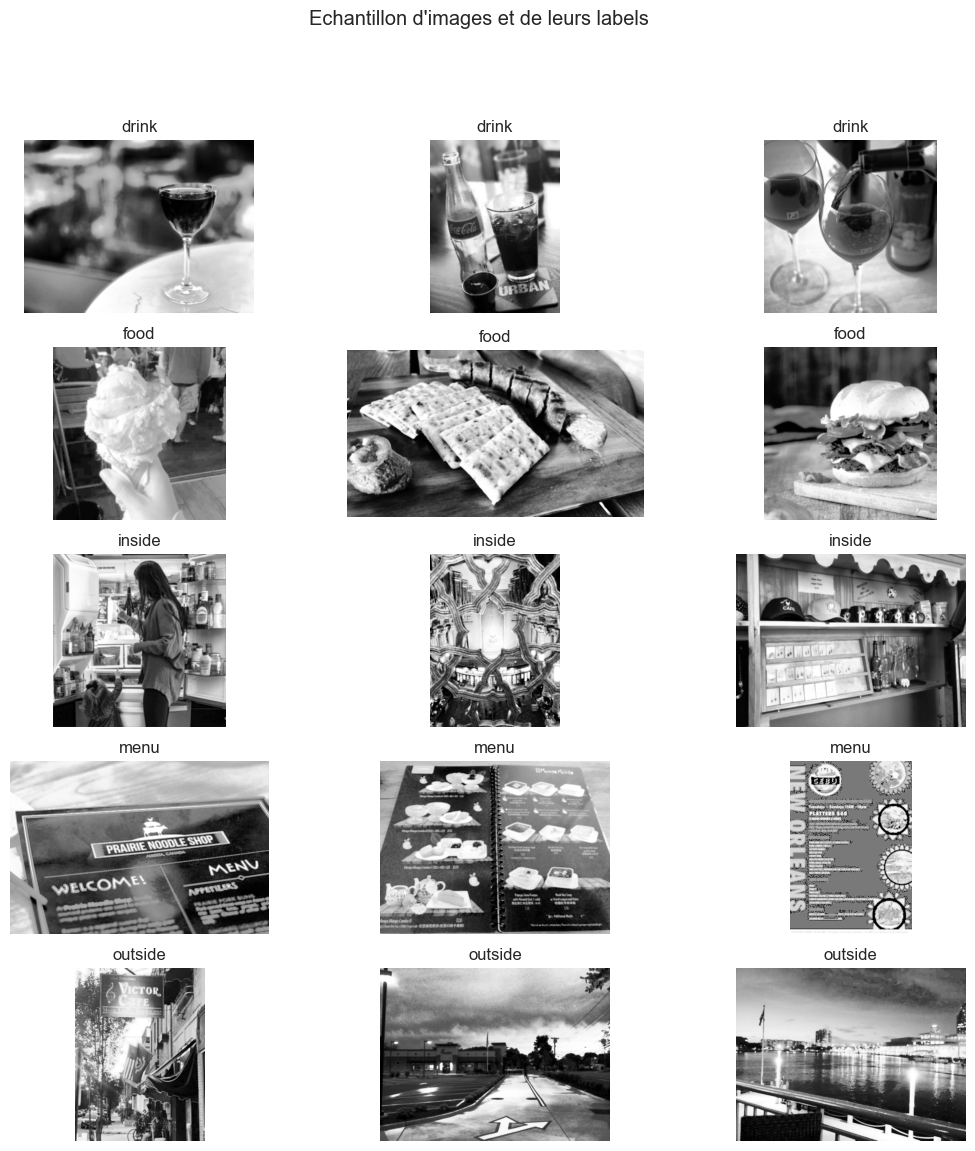

In [36]:
def show_image_label(image, label):
    """
    Affiche une image avec son label.
    Args:
        image (numpy.ndarray): Image à afficher.
        label (str): Label à utiliser comme titre de l'image.
    """
    plt.imshow(image, "gray")
    plt.axis("off")
    plt.title(label)


# Liste des indices des images à afficher
img_indices = [0, 1, 2, 201, 202, 203, 401, 402, 403, 601, 602, 603, 801, 802, 803]
plt.figure(figsize=(13, 13))
for i in range(15):
    plt.subplot(5, 3, i + 1)
    show_image_label(images[img_indices[i]], labels[img_indices[i]])
plt.suptitle("Echantillon d'images et de leurs labels")

### Extraction de features : SIFT

In [37]:
%%time


def extract_features_sift(img):
    """
    Extrait les descripteurs de caractéristiques SIFT d'une image.

    Args:
        img (numpy.ndarray): L'image à partir de laquelle les caractéristiques doivent être extraites.

    Returns:
        des (numpy.ndarray): Le descripteur SIFT pour l'image.
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return des


# Extraire les caractéristiques de toutes les images
sift_keypoints = []
for img in images:
    sift_keypoints.append(extract_features_sift(img))
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

CPU times: total: 18.7 s
Wall time: 1min


In [38]:
print("Nombres de descripteurs :", sift_keypoints_all.shape)

Nombres de descripteurs : (1595173, 128)


Nous allons utiliser la racine carré du nombre de descripteurs comme nombre de clusters afin de regrouper uniquement les descripteurs qui sont les plus proches et obtenir un nombre maximal de clusters possibles pour les descripteurs.
Une autre méthode est de prendre le nombre de catégories que l'on veut traiter et le multiplier par 10 pour obtenir le nombre minimal de clusters possibles pour les descripteurs.  

In [39]:
k = int(round(np.sqrt(len(sift_keypoints_all))))
# k = df_images.label.nunique() * 10
print("Création de", k, "clusters de descripteurs")

Création de 1263 clusters de descripteurs


In [40]:
%%time
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_keypoints_all)

C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: total: 28.5 s
Wall time: 31.7 s


MiniBatchKMeans(n_clusters=1263, random_state=0)

Nous allons transformer chaque image en un vecteur de caractéristiques qui décrit la distribution de ses descripteurs SIFT sur les clusters k-means.

In [41]:
def build_histogram(kmeans, des, image_num):
    """
    Construit un histogramme des descripteurs SIFT en utilisant le clustering k-means.

    Args:
        kmeans (sklearn.cluster.KMeans): Le modèle k-means utilisé pour le clustering.
        des (numpy.ndarray): Le descripteur SIFT de l'image.
        image_num (int): Le numéro de l'image (utilisé pour l'itération des images').

    Returns:
        hist (numpy.ndarray): L'histogramme des descripteurs SIFT.
    """
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problèmes histogramme image")
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    hist = build_histogram(kmeans, image_desc, i)  
    hist_vectors.append(hist)  

im_features = np.asarray(hist_vectors)

   Si l'ensemble de données est de grande dimension, il est recommandé de procéder à une analyse en composantes principales, faute de quoi la malédiction de la dimensionnalité peut poser problème. La TSNE part de l'hypothèse d'une linéarité locale qui peut ne pas être valable en haute dimension, où le collecteur peut varier, et l'ACP peut aider à résoudre ce problème en réduisant la dimensionnalité des données. Pour le nombre de composantes, nous fixerons sont nombre afin de conserver une variance totale de 95%.

In [42]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.95, random_state=0)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="random", random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = labels
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1000, 1263)
Dimensions dataset après réduction PCA :  (1000, 490)
(1000, 3)


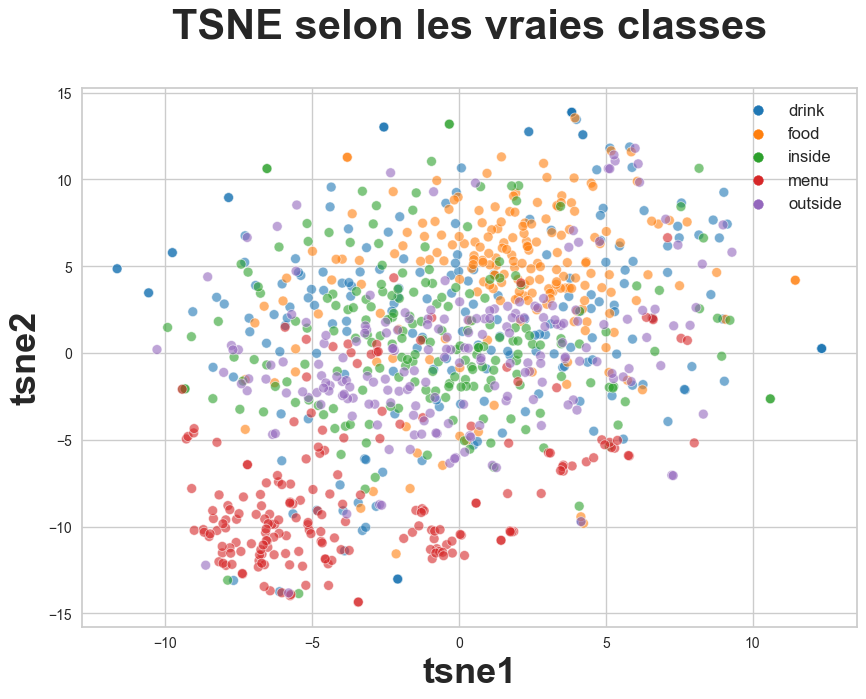

In [43]:
palette = sns.color_palette("tab10", n_colors=5)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    data=df_tsne,
    legend="brief",
    palette=palette,
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les vraies classes", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 12})

plt.show()

In [44]:
cls = KMeans(n_clusters=5, random_state=0)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
display(df_tsne.head())

C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,tsne1,tsne2,class,cluster
0,-7.282878,6.749982,drink,2
1,-9.064487,2.374150,drink,2
2,-4.307463,1.678146,drink,2
3,-11.641148,4.850898,drink,2
4,-0.249983,3.446136,drink,2


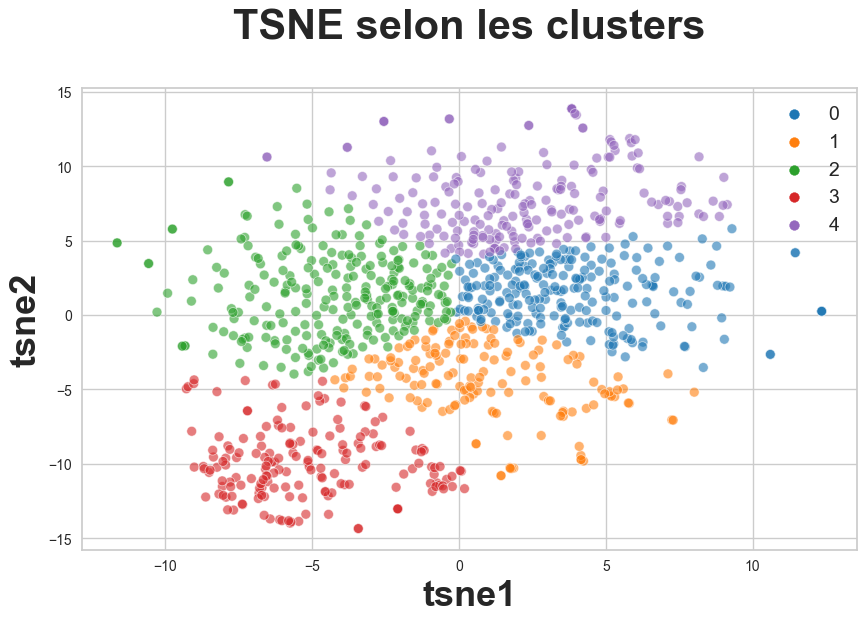

ARI :  0.15941096638122362


In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="cluster",
    palette=palette,
    data=df_tsne,
    legend="brief",
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les clusters", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 14})

plt.show()

print("ARI : ", adjusted_rand_score(labels, cls.labels_))

In [46]:
df_tsne.cluster.value_counts()

cluster
2    249
0    225
4    201
3    173
1    152
Name: count, dtype: int64

In [47]:
def confusion(y_test, y_pred):
    """
    Génère une matrice de confusion sous forme de DataFrame Pandas.

    Args:
        y_test (list or np.array): Les valeurs réelles de y.
        y_pred (list or np.array): Les valeurs prédites de y.

    Returns:
        mat (pd.DataFrame): La matrice de confusion.
    """
    list_labels = ["drink", "food", "inside", "menu", "outside"]
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [i for i in mat.columns]
    mat.index = [i for i in list_labels]
    return mat

In [48]:
labels_encoded = LabelEncoder().fit_transform(labels)
conf_mat_sift = confusion(labels_encoded, cls.labels_)

Text(0.5, 1.0, 'Matrice de confusion')

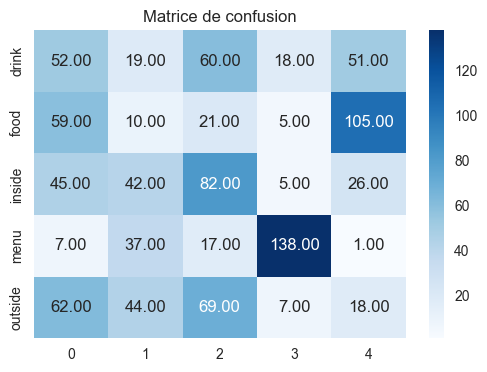

In [49]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_sift, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")

#### Enchainement des étapes de nettoyage et de création de variables (SIFT)

In [50]:
class Sampler(BaseEstimator, TransformerMixin):
    """
    Cette classe est utilisée pour échantillonner un nombre spécifique d'échantillons pour chaque label du jeu de données.
    """

    def __init__(self, n_samples_per_label):
        self.n_samples_per_label = n_samples_per_label

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.groupby("label").sample(n=self.n_samples_per_label, random_state=6)


class ImageLoader(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour charger les images à partir d'un répertoire spécifié.
    """

    def __init__(self, input_dir):
        self.input_dir = input_dir

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        image_paths = []
        for index, row in X.iterrows():
            # Obtenir l'ID de l'image
            image_id = row["photo_id"]
            # Obtenir le chemin de l'image
            image_path = os.path.join(self.input_dir, f"{image_id}.jpg")
            image_paths.append(image_path)
        return image_paths


class ImagePreprocessor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour prétraiter les images.
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_images = []
        for image_path in X:
            preprocessed_images.append(preprocess_image(image_path))
        return preprocessed_images


class SiftFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour extraire les caractéristiques des images en utilisant l'algorithme SIFT
    et pour créer un histogramme des features à l'aide de l'algorithme KMeans.
    """

    def __init__(self):
        self.kmeans = None

    def fit(self, X, y=None):
        # Extraire les caractéristiques de toutes les images
        sift_keypoints = []
        for img in X:
            sift_keypoints.append(extract_features_sift(img))
        sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)
        n_clusters = int(round(np.sqrt(len(sift_keypoints_all))))
        # Former le modèle KMeans
        self.kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
        self.kmeans.fit(sift_keypoints_all)
        return self

    def transform(self, X):
        hist_vectors = []
        for img in X:
            des = extract_features_sift(img)
            hist = self.build_histogram(des)
            hist_vectors.append(hist)
        return np.asarray(hist_vectors)

    def build_histogram(self, des):
        res = self.kmeans.predict(des)
        hist = np.zeros(len(self.kmeans.cluster_centers_))
        nb_des = len(des)
        if nb_des == 0:
            print("problèmes histogramme image")
        for i in res:
            hist[i] += 1.0 / nb_des
        return hist


image_processing_pipeline = Pipeline(
    [
        ("sampler", Sampler(n_samples_per_label=10)),
        ("loader", ImageLoader(input_dir)),
        ("preprocessing", ImagePreprocessor()),
        ("feature_extraction", SiftFeatureExtractor()),
    ]
)

hist_vectors = image_processing_pipeline.fit_transform(df_images)

C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [51]:
print(hist_vectors)
print(hist_vectors.shape)

[[0.00363636 0.00727273 0.         ... 0.00727273 0.00363636 0.00727273]
 [0.00677966 0.00338983 0.00677966 ... 0.00338983 0.00338983 0.00508475]
 [0.00289855 0.         0.0115942  ... 0.0057971  0.00289855 0.        ]
 ...
 [0.00175994 0.0031679  0.00915171 ... 0.00070398 0.00175994 0.00211193]
 [0.00248756 0.00932836 0.00373134 ... 0.00186567 0.00124378 0.00310945]
 [0.00364631 0.         0.00820419 ... 0.00638104 0.00273473 0.00546946]]
(50, 264)


Nous obtenons bien une représentation vectorielle pour chacune de nos images, obtenue grâce à la méthode SIFT et au clustering.

### VGG-16

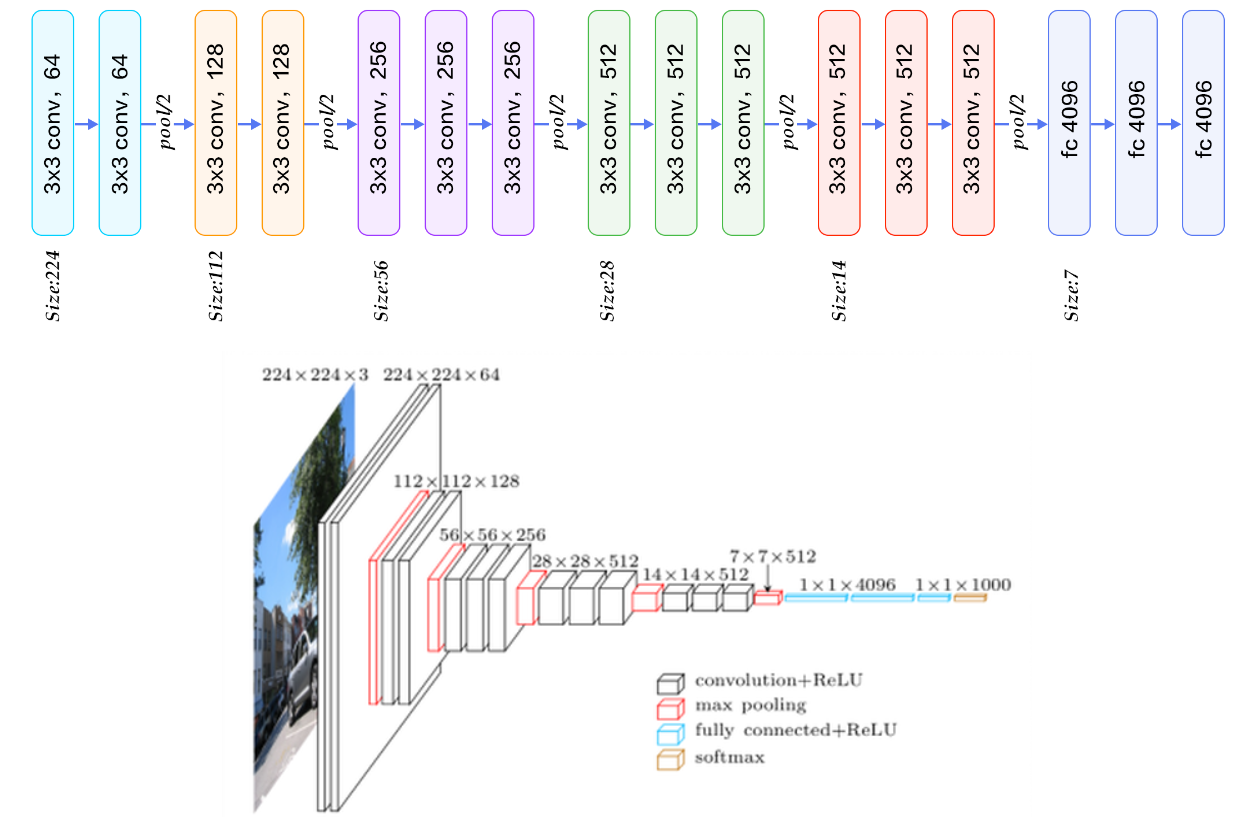

- **Performance**: VGG-16 a démontré une performance exceptionnelle sur l'ensemble de données ImageNet et continue d'être un choix populaire pour la tâche d'extraction de caractéristiques malgré l'existence de modèles plus récents et potentiellement plus performants. Il peut capturer des caractéristiques complexes à partir d'images de manière efficace.

- **Architecture simple**: VGG-16 a une architecture simple et intuitive composée uniquement de couches de convolution 3x3 et de couches max pooling. Cela le rend facile à comprendre et à utiliser. De plus, malgré sa simplicité, VGG-16 est capable d'extraire des caractéristiques très informatives.

- **Généralisation**: VGG-16 a une excellente capacité de généralisation, ce qui signifie qu'il est capable de bien fonctionner sur une grande variété de tâches et de types de données différents.

- **Pré-entraînement sur ImageNet**: VGG-16 a été pré-entraîné sur l'ensemble de données ImageNet, qui contient plus de 14 millions d'images annotées et couvre une large gamme de catégories d'objets. Cela signifie que le modèle a déjà appris à reconnaître une grande variété de caractéristiques d'images, ce qui peut être très utile pour l'extraction de caractéristiques.

In [52]:
def extract_features_vgg(images):
    """
    Extrait des caractéristiques à partir d'un ensemble d'images en utilisant le modèle pré-entraîné VGG16.

    Args:
        images (liste de ndarray): liste d'images à partir desquelles extraire les caractéristiques.
        Chaque élément de la liste doit être un tableau numpy représentant une image.

    Returns:
        ndarray: tableau numpy de caractéristiques extraites.
        Chaque ligne correspond à une image et chaque colonne à une caractéristique.
    """
    model = VGG16(weights="imagenet", include_top=False)
    features_vgg16 = []

    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_size = (224, 224)
        img = cv2.resize(img, img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        features_vgg16.append(features)
    features_vgg16 = np.asarray(features_vgg16)
    
    return features_vgg16


features_vgg = extract_features_vgg(images)

1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 76ms/step


In [53]:
features_vgg_flattened = features_vgg.reshape((1000, -1))

In [54]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.95, random_state=0)
feat_pca = pca.fit_transform(features_vgg_flattened)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="random", random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = labels
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1000, 1263)
Dimensions dataset après réduction PCA :  (1000, 799)
(1000, 3)


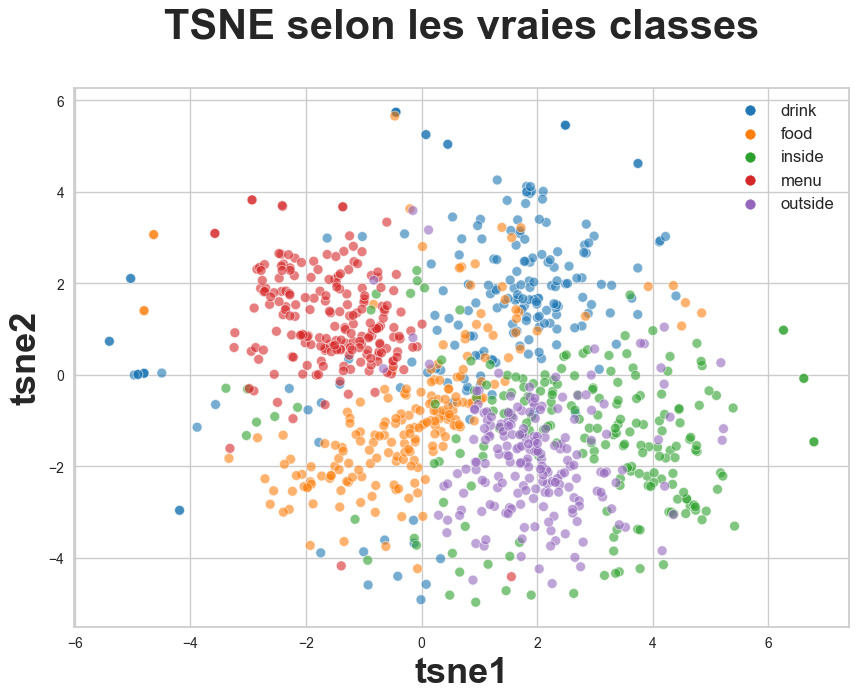

In [55]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    data=df_tsne,
    legend="brief",
    palette=palette,
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les vraies classes", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 12})

plt.show()

In [56]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features_vgg_flattened)
df_tsne["cluster"] = kmeans.labels_
ari_score = adjusted_rand_score(labels_encoded, kmeans.labels_)

C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


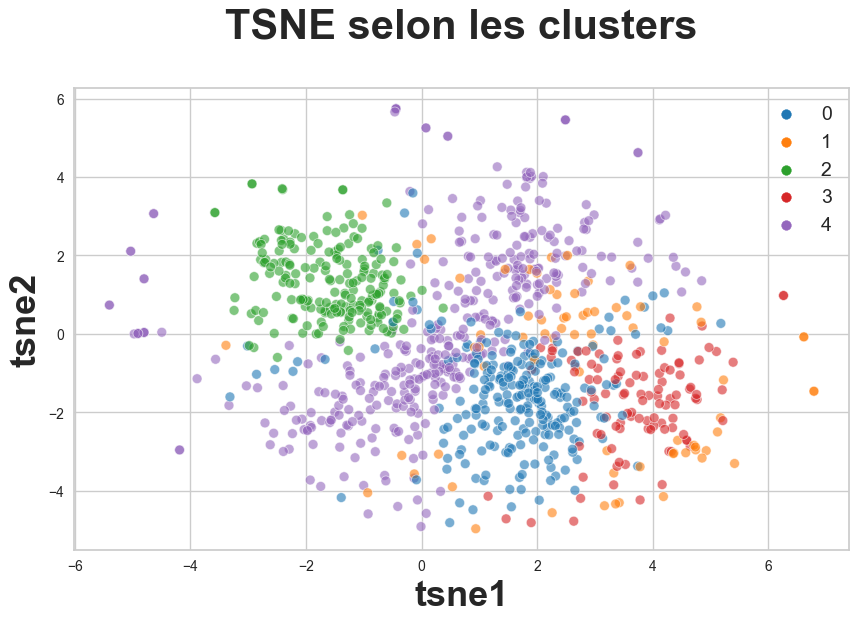

ARI :  0.5153675040964664


In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="cluster",
    palette=palette,
    data=df_tsne,
    legend="brief",
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les clusters", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 14})

plt.show()

print("ARI : ", adjusted_rand_score(labels_encoded, kmeans.labels_))

Text(0.5, 1.0, 'Matrice de confusion')

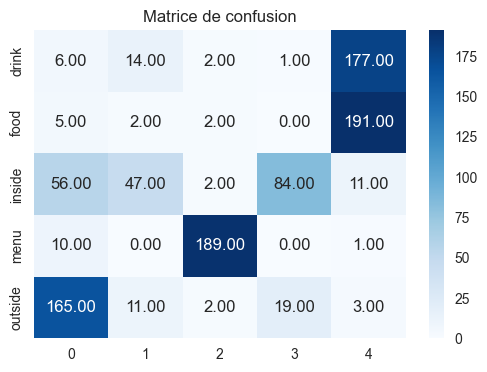

In [58]:
conf_mat_vgg = confusion(labels_encoded, kmeans.labels_)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_vgg, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")

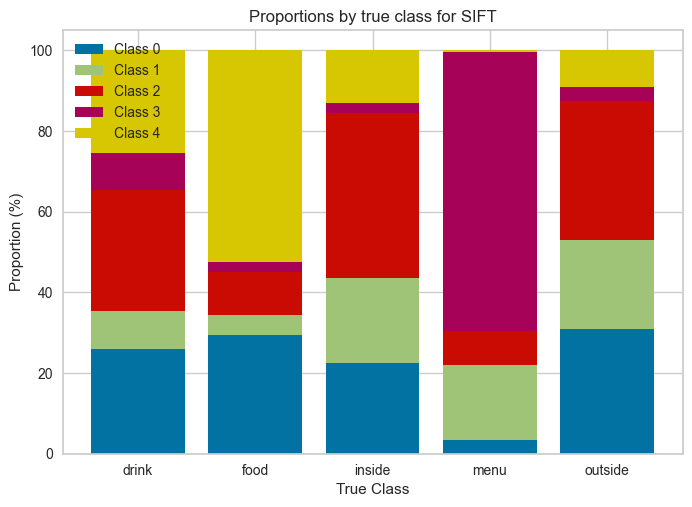

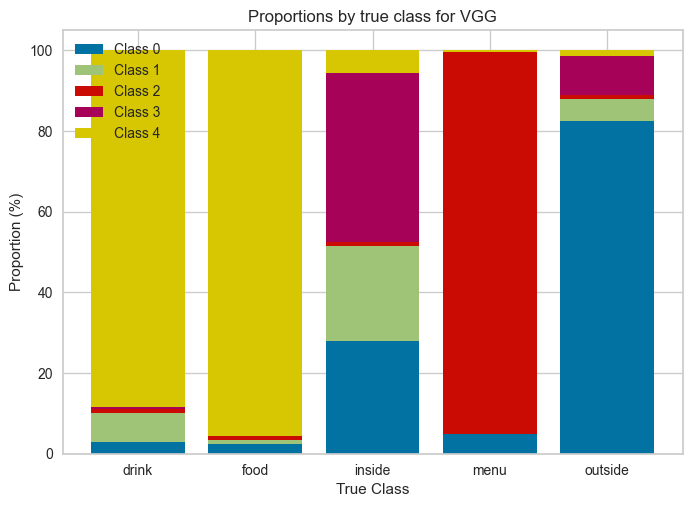

In [59]:
def plot_stacked_bar(df, title):
    """
    Trace un diagramme à barres empilées à partir d'un DataFrame pour visualiser les proportions de classes prédites pour chaque
    classe réelle dans un problème de classification.

    Args:
        df (DataFrame): DataFrame à partir duquel le graphique est tracé.
                        Les lignes correspondent aux classes réelles et les colonnes aux classes prédites.
        title (str)   : Titre du graphique.
    """
    df = df.div(df.sum(axis=1), axis=0) * 100
    labels = df.index
    num_labels = len(labels)
    x = np.arange(num_labels)  

    fig, ax = plt.subplots()
    for i in range(df.shape[1]):
        if i == 0:
            ax.bar(x, df.iloc[:, i], label="Class " + str(i))
        else:
            ax.bar(
                x,
                df.iloc[:, i],
                bottom=df.iloc[:, :i].sum(axis=1),
                label="Class " + str(i),
            )

    ax.set_xlabel("True Class")
    ax.set_ylabel("Proportion (%)")
    ax.set_title(f"Proportions by true class for {title}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


plot_stacked_bar(conf_mat_sift, "SIFT")
plot_stacked_bar(conf_mat_vgg, "VGG")

#### #### Enchaînement des étapes de nettoyage et de création de variables (VGG)

In [60]:
class VGGFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Un transformateur personnalisé qui utilise le modèle VGG16 pour extraire les caractéristiques des images.
    """

    def __init__(self):
        self.model = VGG16(weights="imagenet", include_top=False)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features_vgg16 = []

        for img in X:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img_size = (224, 224)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)

            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            features = self.model.predict(img_array)
            features_vgg16.append(features)

        return np.asarray(features_vgg16)


image_processing_pipeline = Pipeline(
    [
        ("sampler", Sampler(n_samples_per_label=10)),
        ("loader", ImageLoader(input_dir)),
        ("preprocessing", ImagePreprocessor()),
        ("feature_extraction", VGGFeatureExtractor()),
    ]
)

vgg_features = image_processing_pipeline.fit_transform(df_images)

1/1 [==============================] - 0s 79ms/step


In [61]:
print(vgg_features.shape)

(50, 1, 7, 7, 512)


Nous avons bien récupéré nos 50 features extraites à partir de nos 10 images par label